In [1]:
# Import required libraries
import sys
sys.path.append('/g/data/ei56/projects/lawhua/proj_scDeepID/minimal_ablation')

import scDeepID_minimal2 as scDeepID
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/g/data/ei56/projects/lawhua/packages/miniconda3/envs/scgen4/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda')

In [2]:
# Load the test data
adata = sc.read('/g/data/fy54/lawhua/tk_flagship/rna_phase1_b.h5ad')
adata.obs['celltype'] = adata.obs['wg2_scpred_prediction']
print(f"Cell type distribution:\n{adata.obs['celltype'].value_counts()}")

# Extract raw data (important for accessing all genes)
adata = adata.raw.to_adata()
print(f"Expression range: {adata.X.min():.2f} to {adata.X.max():.2f}")

# Use gene names as variable names and ensure uniqueness
adata.var_names = adata.var['gene_name'].astype(str).str.upper()
adata.var_names_make_unique()
print(f"Processed {len(adata.var_names)} genes")
print(f"Data shape: {adata.shape}")

Cell type distribution:
celltype
B_naive           320331
B_intermediate    119893
B_memory           99596
Name: count, dtype: int64
Expression range: 0.00 to 8.21
Processed 36842 genes
Data shape: (539820, 36842)


In [3]:
# Preprocess the data
# Use the same preprocessing as training
adata_pre = scDeepID.preprocess(
    adata, 
    gmt_path='human_gobp_2024',  # Adjust based on what was used in training
    hvg_num=None  # Adjust based on training
)
print(f"Preprocessed data shape: {adata_pre.shape}")

check db adata shape:  (539820, 16330)


/g/data/ei56/projects/lawhua/packages/miniconda3/envs/scgen4/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:696: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


check adata shape:  (539820, 2351)
Preprocessed data shape: (539820, 2351)


In [4]:
attn_adata = sc.read("/g/data/ei56/projects/lawhua/proj_scDeepID/minimal_ablation/exp_meanpooling/tk_bcell_minimal2_dbhuman_gobp_2024_seed1234_maxg300_maxgs400/attention_umap.h5ad")

In [ ]:
pathway_attr = sc.read("/g/data/ei56/projects/lawhua/proj_scDeepID/minimal_ablation/exp_meanpooling/tk_bcell_minimal2_dbhuman_gobp_2024_seed1234_maxg300_maxgs400/pathway_attributions_meanpooling.h5ad")

In [9]:
pathway_attr_copy = pathway_attr.copy()
sc.pp.normalize_total(pathway_attr_copy)
#sc.pp.log1p(pathway_attr_copy)
sc.pp.scale(pathway_attr_copy, max_value=10)
pathway_attr_copy.obsm['X_umap'] = attn_adata.obsm['X_umap']

#### SMR integration

In [ ]:
# Set up custom font
import matplotlib
import matplotlib.font_manager as font_manager
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'DejaVu Sans'

In [15]:
df_smr = pd.read_parquet('/g/data/fy54/analysis/tenk10k-causal/results/aggregate/tenk10k_phase1.scdrs.cell_score.tsv.parquet.gz')
df_smr_stat = pd.read_parquet('/g/data/fy54/analysis/tenk10k-causal/results/aggregate/tenk10k_phase1.scdrs.cell_mcp.tsv.parquet.gz')
# Check the shape and columns
print(f"Shape: {df_smr.shape}")
print(f"Columns: {df_smr.columns.tolist()}")
print(f"\nFirst few rows:")
print(df_smr.head())
print(df_smr_stat.head())

Shape: (229239, 106)
Columns: ['index', 'cell_type', 'umap_1', 'umap_2', 'cardio_dissect', 'gastricesoph', 'cmelanoma', 'bladder', 'pancreatic', 'ms', 'crohns', 'neut_p', 'SkBmd', 'colorectal', 'leukemia', 'sle', 'covid19_vax2', 'mdd', 'WbBmd', 'stroke', 'mlymph', 'A2_ALL_eur_leave_23andme', 'rbc', 'eo', 'hlr', 'breast_cimba', 'hct', 'irf', 'Luminal_B_HER2Neg', 'hgb', 'SCLC', 'asthma', 'FnBmd', 'wbc', 'mchc', 'squamous', 'uc', 't2dm', 'plt', 'asd', 'mch', 'rectum', 'ret', 'hlr_p', 'Triple_Neg', 'ra', 'cad', 'long_covid', 'B2_ALL_eur_leave_23andme', 'ovary', 'kidney', 'mscv', 'mpv', 'mrv', 'neversmokers', 'LsBmd', 'mcv', 'lymph', 'ch', 'colon', 'alzheimers', 'bdII', 'HER2_Enriched', 'migraine', 'bd', 'basalcc', 'poag', 'eczema', 'lungadeno', 'rdw_cv', 'parkinsons', 'pct', 'endometriosis', 'cervix', 'Luminal_B', 'bdI', 'IPF', 'neut', 'breast_bcac', 'covid19_vax1', 'pancreas', 'C2_ALL_eur_leave_23andme', 'schizophrenia', 'baso', 'eBmd', 'psoriasis', 'adhd', 'mono_p', 'osteoarthritis', 'th

In [16]:
b_cell_types = ['B_naive','B_intermediate', 'B_memory']

df_smr_subset = df_smr[['index' ,'cell_type', 'umap_1', 'umap_2', 'sle']].copy()
df_smr_subset = df_smr_subset[df_smr_subset['cell_type'].isin(b_cell_types)]
df_smr_stat_subst = df_smr_stat[['index', 'cell_type', 'umap_1', 'umap_2', 'sle']].copy()
df_smr_stat_subst = df_smr_stat_subst[df_smr_stat_subst['cell_type'].isin(b_cell_types)]

In [17]:
df_smr_subset

,index,cell_type,umap_1,umap_2,sle
1133,TGATCTTTCATTTCCA_S0020c,B_intermediate,15.899157,6.009265,1.019116
1134,TCGTGCTTCTGGAAGG_S0012a,B_intermediate,13.419460,6.133640,3.480560
1135,ATTGTTCGTATCGAAA_S0140,B_intermediate,12.694070,3.289053,0.360395
1136,AGGGCTCTCCAATCTT_S0033a,B_intermediate,13.556185,5.684330,2.075679
1137,AGGGCTCGTGTCCCTT_S0165,B_intermediate,14.208659,6.217813,1.524137
...,...,...,...,...,...
31128,TGGGTTATCAACCCGG_S0003c,B_naive,8.710870,5.622322,1.387243
31129,GACAGCCCAGAGTCTT_S0038a,B_naive,11.167953,3.769384,2.476315
31130,TGTGCGGAGGGTTGCA_S0148,B_naive,10.729033,6.219125,1.319929
31131,ACCTGAAAGGGTTGCA_S0210,B_naive,8.785102,6.237010,0.379819


In [18]:
df_smr_stat_subst

,index,cell_type,umap_1,umap_2,sle
1133,TGATCTTTCATTTCCA_S0020c,B_intermediate,15.899157,6.009265,0.155844
1134,TCGTGCTTCTGGAAGG_S0012a,B_intermediate,13.419460,6.133640,0.000999
1135,ATTGTTCGTATCGAAA_S0140,B_intermediate,12.694070,3.289053,0.341658
1136,AGGGCTCTCCAATCTT_S0033a,B_intermediate,13.556185,5.684330,0.027972
1137,AGGGCTCGTGTCCCTT_S0165,B_intermediate,14.208659,6.217813,0.075924
...,...,...,...,...,...
31128,TGGGTTATCAACCCGG_S0003c,B_naive,8.710870,5.622322,0.091908
31129,GACAGCCCAGAGTCTT_S0038a,B_naive,11.167953,3.769384,0.015984
31130,TGTGCGGAGGGTTGCA_S0148,B_naive,10.729033,6.219125,0.106893
31131,ACCTGAAAGGGTTGCA_S0210,B_naive,8.785102,6.237010,0.346653


In [ ]:
common_cells = list(set(pathway_attr_copy.obs_names) & set(df_smr_subset['index']))
print(f"Number of common cells: {len(common_cells)}")
pathway_attr_subset = pathway_attr_copy[common_cells].copy()
df_smr_indexed = df_smr_subset.set_index('index')
df_smr_stat_indexed = df_smr_stat_subst.set_index('index')
pathway_attr_subset.obs['sle'] = df_smr_indexed.loc[pathway_attr_subset.obs_names, 'sle'].values
pathway_attr_subset.obs['sle_pval'] = df_smr_stat_indexed.loc[pathway_attr_subset.obs_names, 'sle'].values
print(f"Subsetted shape: {pathway_attr_subset.shape}")
print(f"SLE scores added: {'sle' in pathway_attr_subset.obs.columns}")
print(f"SLE score range: {pathway_attr_subset.obs['sle'].min():.3f} to {pathway_attr_subset.obs['sle'].max():.3f}")
pathway_attr_subset.obs['umap_1_scdrs'] = df_smr_indexed.loc[pathway_attr_subset.obs_names,
'umap_1'].values
pathway_attr_subset.obs['umap_2_scdrs'] = df_smr_indexed.loc[pathway_attr_subset.obs_names,
'umap_2'].values

Number of common cells: 30000
Subsetted shape: (30000, 400)
SLE scores added: True
SLE score range: -2.907 to 7.128


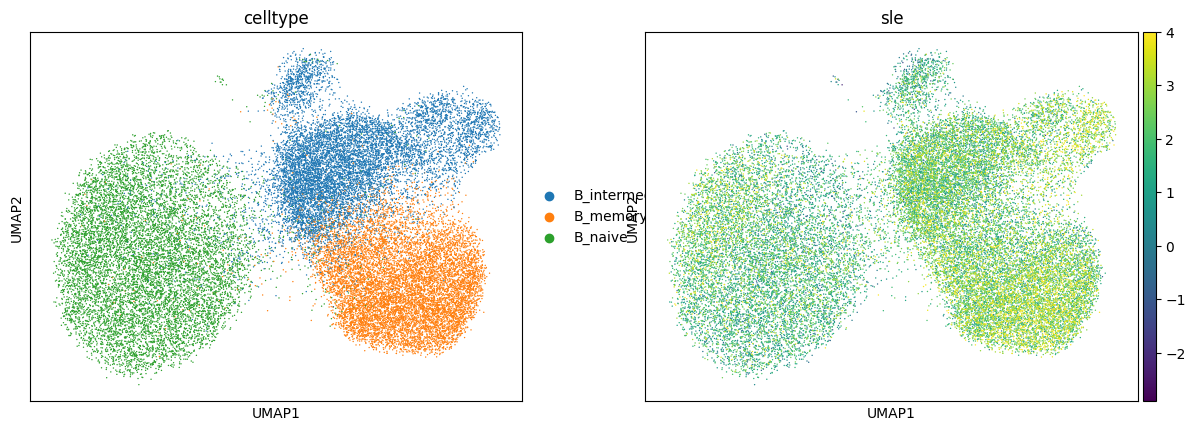

In [21]:
sc.pl.umap(pathway_attr_subset,color=['celltype',"sle"], vmax=4)


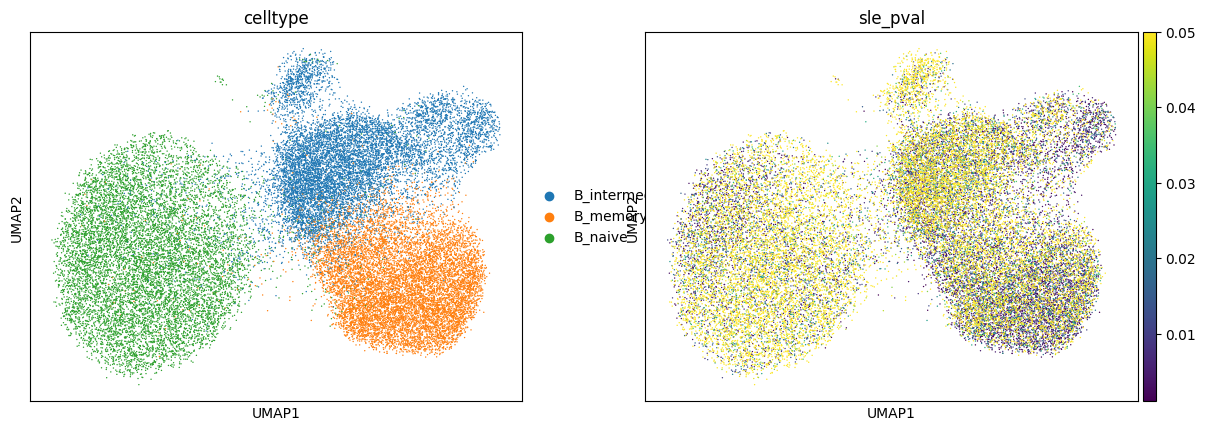

In [22]:
sc.pl.umap(pathway_attr_subset,color=['celltype',"sle_pval"], vmax=0.05)

In [26]:
from scipy import stats

# Create SLE status column
pathway_attr_subset.obs['sle_status'] = ['SLE' if pval < 0.05 else 'Non-SLE'
                                        for pval in pathway_attr_subset.obs['sle_pval']]

Total pathways tested: 400
FDR < 0.05: 202
FDR < 0.05 & mean > 0.2: 73


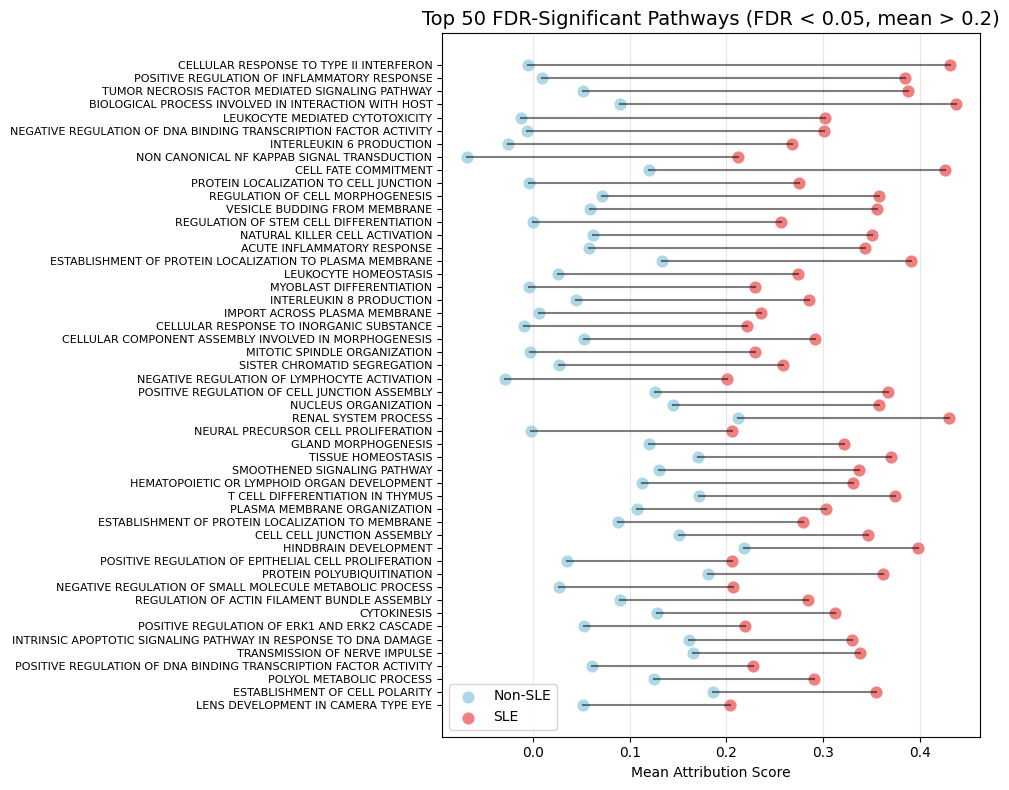


Top 50 FDR-significant pathways:
GOBP_CELLULAR_RESPONSE_TO_TYPE_II_INTERFERON: p=3.848e-251, FDR=1.539e-248, -log10(p)=250.41
GOBP_POSITIVE_REGULATION_OF_INFLAMMATORY_RESPONSE: p=5.379e-188, FDR=1.076e-185, -log10(p)=187.27
GOBP_TUMOR_NECROSIS_FACTOR_MEDIATED_SIGNALING_PATHWAY: p=1.974e-163, FDR=2.633e-161, -log10(p)=162.70
GOBP_BIOLOGICAL_PROCESS_INVOLVED_IN_INTERACTION_WITH_HOST: p=1.677e-149, FDR=1.677e-147, -log10(p)=148.78
GOBP_LEUKOCYTE_MEDIATED_CYTOTOXICITY: p=1.252e-132, FDR=1.001e-130, -log10(p)=131.90
GOBP_NEGATIVE_REGULATION_OF_DNA_BINDING_TRANSCRIPTION_FACTOR_ACTIVITY: p=7.647e-131, FDR=5.098e-129, -log10(p)=130.12
GOBP_INTERLEUKIN_6_PRODUCTION: p=5.273e-129, FDR=3.013e-127, -log10(p)=128.28
GOBP_NON_CANONICAL_NF_KAPPAB_SIGNAL_TRANSDUCTION: p=1.021e-117, FDR=4.537e-116, -log10(p)=116.99
GOBP_CELL_FATE_COMMITMENT: p=7.841e-117, FDR=3.136e-115, -log10(p)=116.11
GOBP_PROTEIN_LOCALIZATION_TO_CELL_JUNCTION: p=3.420e-109, FDR=1.244e-107, -log10(p)=108.47
GOBP_REGULATION_OF_CELL_

In [39]:
from statsmodels.stats.multitest import multipletests
# 1. Calculate t-test for all pathways
p_values = []
pathway_names = []
sle_means = []
non_sle_means = []
for pathway in pathway_attr_subset.var_names:
    # Extract data
    sle_data = pathway_attr_subset[pathway_attr_subset.obs['sle_status'] ==
'SLE', pathway].X.flatten()
    non_sle_data = pathway_attr_subset[pathway_attr_subset.obs['sle_status'] ==
'Non-SLE', pathway].X.flatten()
    # T-test for SLE > Non-SLE
    t_stat, p_val = stats.ttest_ind(sle_data, non_sle_data,
alternative='greater')
    p_values.append(p_val)
    pathway_names.append(pathway)
    sle_means.append(sle_data.mean())
    non_sle_means.append(non_sle_data.mean())
# Calculate FDR
_, fdr_values, _, _ = multipletests(p_values, method='fdr_bh')
# 2. Convert to -log10(p) and rank
neg_log_p = -np.log10(np.array(p_values))
results_df = pd.DataFrame({
    'pathway': pathway_names,
    'neg_log_p': neg_log_p,
    'p_value': p_values,
    'fdr': fdr_values,
    'sle_mean': sle_means,
    'non_sle_mean': non_sle_means
})
results_df_raw = results_df.copy()
results_df_raw = results_df_raw.sort_values('neg_log_p', ascending=False)
# Filter: FDR < 0.05 AND at least one group should have mean > 0.2
results_df = results_df[(results_df['fdr'] < 0.05) &
                        ((results_df['sle_mean'] > 0.2) |
(results_df['non_sle_mean'] > 0.2))]
# Sort by -log10(p)
results_df = results_df.sort_values('neg_log_p', ascending=False)
# Print FDR summary
print(f"Total pathways tested: {len(p_values)}")
print(f"FDR < 0.05: {sum(fdr_values < 0.05)}")
print(f"FDR < 0.05 & mean > 0.2: {len(results_df)}")
# 3. Create dumbbell plot for top FDR-significant pathways
n_pathways = min(50, len(results_df))  # Show up to 50, or all if fewer
top_pathways = results_df.head(n_pathways)
fig, ax = plt.subplots(figsize=(10, 8))  # Increased height from 5 to 15
# Plot lines connecting the two groups
for i, (idx, row) in enumerate(top_pathways.iterrows()):
    # Reverse the y-position: use (n_pathways - 1 - i) instead of i
    y_pos = n_pathways - 1 - i
    ax.plot([row['non_sle_mean'], row['sle_mean']], [y_pos, y_pos], 'k-', alpha=0.5)
    # Plot dots (reduced size from 100 to 60 for better visibility with more pathways)
    ax.scatter(row['non_sle_mean'], y_pos, color='lightblue', s=60, label='Non-SLE'
if i==0 else "")
    ax.scatter(row['sle_mean'], y_pos, color='lightcoral', s=60, label='SLE' if
i==0 else "")
# Format plot - REVERSED LABELS HERE
ax.set_yticks(range(n_pathways))
# Reverse the pathway labels to match the reversed y-positions
reversed_labels = top_pathways['pathway'].str.replace('GOBP_', '').str.replace('_', ' ').tolist()[::-1]
ax.set_yticklabels(reversed_labels, fontsize=8)
ax.set_xlabel('Mean Attribution Score')
ax.set_title(f'Top {n_pathways} FDR-Significant Pathways (FDR < 0.05, mean > 0.2)', fontsize=14)
ax.legend()
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('/g/data/ei56/projects/lawhua/proj_scDeepID/minimal_ablation/exp_meanpooling/tk_bcell_minimal2_dbhuman_gobp_2024_seed1234_maxg300_maxgs400/smr_plot/top50_fdr_pathways.pdf', dpi=300,bbox_inches='tight')  # Updated filename
plt.show()
# Print stats with FDR
print(f"\nTop {n_pathways} FDR-significant pathways:")
for i, row in top_pathways.iterrows():
    print(f"{row['pathway']}: p={row['p_value']:.3e}, FDR={row['fdr']:.3e}, -log10(p)={row['neg_log_p']:.2f}")

In [28]:
# Plot pathways with cell type reference
pathways_to_plot = top_pathways[0:5]['pathway'].tolist()  # Convert to list
pathways_to_plot_umap = pathways_to_plot.copy()
pathways_to_plot_umap.insert(0, 'celltype')
fig = sc.pl.umap(pathway_attr_subset, color=pathways_to_plot_umap,
                   cmap='magma_r', vmax=5, size=3, ncols=5,
                   return_fig=True, show=False)
for ax in fig.get_axes():
      for artist in ax.collections:
          artist.set_rasterized(True)
# Now you can save with plt
fig.savefig('/g/data/ei56/projects/lawhua/proj_scDeepID/minimal_ablation/exp_meanpooling/tk_bcell_minimal2_dbhuman_gobp_2024_seed1234_maxg300_maxgs400/smr_plot/pathway_umap_custom.pdf', dpi=300, bbox_inches='tight')
plt.close(fig)

In [97]:
for pathway in pathways_to_plot_umap:
      if pathway != 'celltype':
          max_val = pathway_attr_subset[:, pathway].X.max()
          print(f"{pathway}: {max_val:.3f}")

GOBP_CELLULAR_RESPONSE_TO_TYPE_II_INTERFERON: 10.000
GOBP_POSITIVE_REGULATION_OF_INFLAMMATORY_RESPONSE: 9.827
GOBP_TUMOR_NECROSIS_FACTOR_MEDIATED_SIGNALING_PATHWAY: 6.574
GOBP_BIOLOGICAL_PROCESS_INVOLVED_IN_INTERACTION_WITH_HOST: 8.651
GOBP_LEUKOCYTE_MEDIATED_CYTOTOXICITY: 8.253


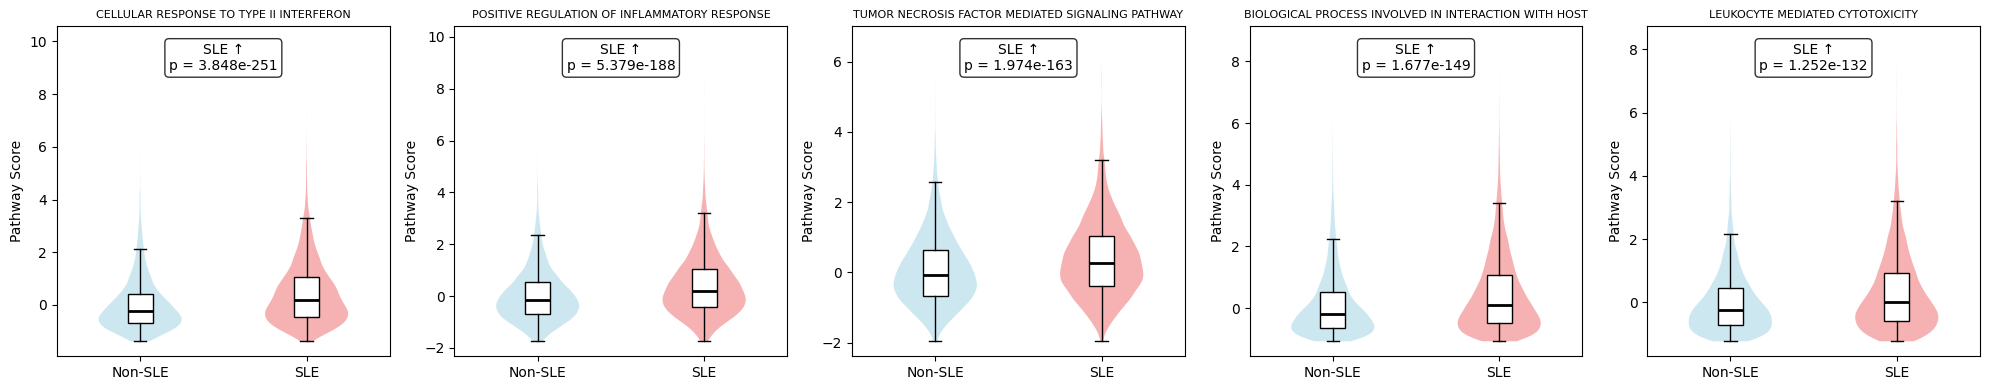

In [92]:
# Plot violin with boxplot overlay
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

# Define colors
colors = ['lightblue', 'lightcoral']  # Non-SLE: blue, SLE: red

for i, pathway in enumerate(pathways_to_plot):
    # Extract data
    sle_data = pathway_attr_subset[pathway_attr_subset.obs['sle_status'] ==
'SLE', pathway].X.flatten()
    non_sle_data = pathway_attr_subset[pathway_attr_subset.obs['sle_status'] ==
'Non-SLE', pathway].X.flatten()

    # Calculate means
    sle_mean = sle_data.mean()
    non_sle_mean = non_sle_data.mean()

    # Perform one-sided t-test (SLE > Non-SLE)
    t_stat, p_value_greater = stats.ttest_ind(sle_data, non_sle_data,
alternative='greater')

    # Create violin plot
    parts = axes[i].violinplot([non_sle_data, sle_data], positions=[1, 2],
                                showmeans=False, showmedians=False,
showextrema=False)

    # Color the violins differently
    for j, pc in enumerate(parts['bodies']):
        pc.set_facecolor(colors[j])
        pc.set_alpha(0.6)

    # Overlay boxplot without outliers
    bp = axes[i].boxplot([non_sle_data, sle_data], positions=[1, 2],
                        widths=0.15, showfliers=False,
                        patch_artist=True,
                        boxprops=dict(facecolor='white', color='black'),
                        medianprops=dict(color='black', linewidth=2))

    # Set labels and title
    axes[i].set_xticks([1, 2])
    axes[i].set_xticklabels(['Non-SLE', 'SLE'])
    axes[i].set_title(pathway.replace('GOBP_', '').replace('_', ' '),
fontsize=8)
    axes[i].set_ylabel('Pathway Score')

    # Add p-value and direction to plot
    direction = "↑" if sle_mean > non_sle_mean else "↓"
    axes[i].text(0.5, 0.95, f'SLE {direction}\np = {p_value_greater:.3e}',
                transform=axes[i].transAxes,
                ha='center', va='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('/g/data/ei56/projects/lawhua/proj_scDeepID/minimal_ablation/exp_meanpooling/tk_bcell_minimal2_dbhuman_gobp_2024_seed1234_maxg300_maxgs400/smr_plot/top5violin.pdf', dpi=300,bbox_inches='tight')
plt.show()

In [103]:
results_df_raw.to_csv("/g/data/ei56/projects/lawhua/proj_scDeepID/minimal_ablation/exp_meanpooling/tk_bcell_minimal2_dbhuman_gobp_2024_seed1234_maxg300_maxgs400/smr_plot/pathway_test.csv", index=False)

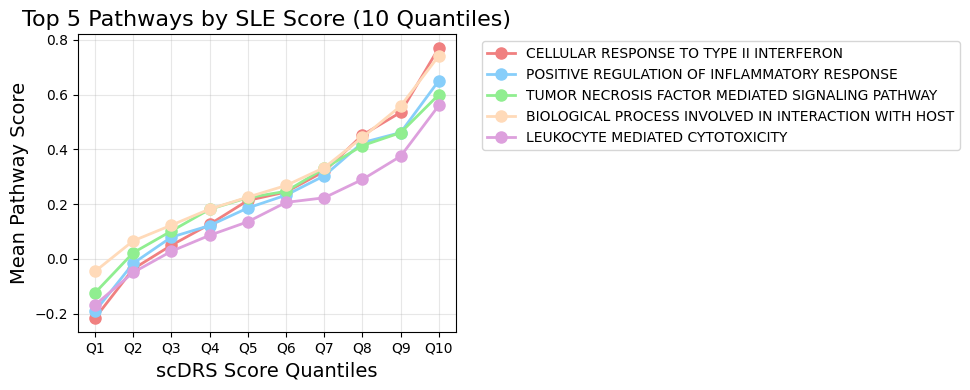

In [ ]:
top5_pathways = results_df.head(5)['pathway'].tolist()
plt.figure(figsize=(10, 4))  # Slightly wider figure for 10 points
colors = ['lightcoral', 'lightskyblue', 'lightgreen', 'peachpuff', 'plum']
for pathway, color in zip(top5_pathways, colors):
    # Get data
    sle_scores = pathway_attr_subset.obs['sle'].values
    pathway_scores = pathway_attr_subset[:, pathway].X.flatten()
    # Calculate 10 quantiles
    quantiles = pd.qcut(sle_scores, q=10, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5',
                                                   'Q6', 'Q7', 'Q8', 'Q9', 'Q10'])
    # Calculate means per quantile
    means = []
    for q in ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10']:
        means.append(pathway_scores[quantiles == q].mean())
    # Plot with full pathway name (no truncation)
    plt.plot(range(1, 11), means, marker='o', markersize=8,  # Slightly smaller markers for 10 points
            color=color, linewidth=2,
            label=pathway.replace('GOBP_', '').replace('_', ' '))

plt.xlabel('scDRS Score Quantiles', fontsize=14)
plt.ylabel('Mean Pathway Score', fontsize=14)
plt.title('Top 5 Pathways by SLE Score (10 Quantiles)', fontsize=16)
plt.xticks(range(1, 11), ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/g/data/ei56/projects/lawhua/proj_scDeepID/minimal_ablation/exp_meanpooling/tk_bcell_minimal2_dbhuman_gobp_2024_seed1234_maxg300_maxgs400/smr_plot/top5_quintile.pdf', dpi=300, bbox_inches='tight')
plt.show()